### Sentiment Analysis with Reddit and yfinance
Needless to say, this didn't give great results.

First, I attempted to scrape just Reddit data from the relevant subreddits and do sentiment analysis on that. But not only was there a lot of missing data, the insights were also not very useful...

In [ ]:
import praw
import pandas as pd

In [ ]:
# Set up your Reddit API credentials
reddit = praw.Reddit(
    client_id='3nkSrrB6BcNAIXt1_ReTfw',
    client_secret='2zwvUHenQFeQPVdskvv-Qm1B5AIGuA',
    user_agent='crypto_project_scraper_v1.0 by u/Guilty-Bat-7419'
)

# Choose relevant subreddits for cryptocurrency discussions
subreddits = ['Bitcoin', 'CryptoCurrency', 'CryptoMarkets']

# Scrape posts from each subreddit
posts = []
for subreddit in subreddits:
    for post in reddit.subreddit(subreddit).top(limit=500):  # You can adjust the limit
        posts.append({
            'Subreddit': subreddit,
            'Title': post.title,
            'Text': post.selftext,
            'Score': post.score,
            'Created': pd.to_datetime(post.created_utc, unit='s'),
            'Comments': post.num_comments
        })

# Create a DataFrame from the scraped data
reddit_data = pd.DataFrame(posts)

# Display the first few rows of the DataFrame
print(reddit_data.head())

# Save the data to a CSV file for further use
reddit_data.to_csv('reddit_crypto_posts.csv', index=False)


  Subreddit                                              Title Text  Score  \
0   Bitcoin             It's official! 1 Bitcoin = $10,000 USD       48607   
1   Bitcoin                   The last 3 months in 47 seconds.       48534   
2   Bitcoin  Tesla buys $1.5b in Bitcoin and is looking to ...       45547   
3   Bitcoin                                  It's over 9000!!!       42445   
4   Bitcoin               Everyone who's trading BTC right now       42083   

              Created  Comments  
0 2017-11-29 01:25:24      4411  
1 2018-02-04 02:42:03       761  
2 2021-02-08 12:48:45      2857  
3 2017-11-26 04:55:02      3064  
4 2018-01-06 20:38:56       760  


In [ ]:
# Remove rows with empty or whitespace-only text
reddit_data = reddit_data[reddit_data['Text'].str.strip().astype(bool)]
# Reset the index of the DataFrame
reddit_data.reset_index(inplace=True)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving combined_crypto_analysis_with_urls.csv to combined_crypto_analysis_with_urls (1).csv
Saving coingecko_and_reddit_data.csv to coingecko_and_reddit_data.csv


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to each post's text
reddit_data['VADER_Sentiment'] = reddit_data['Text'].apply(lambda text: analyzer.polarity_scores(str(text))['compound'])

# Display the updated DataFrame with VADER sentiment scores
print(reddit_data[['Text', 'VADER_Sentiment']].head())

                                                Text  VADER_Sentiment
0  Anyone following the WSB drama this morning wi...          -0.2500
1  I'm up more than 110x so I just sold a chunk a...           0.6030
2  Hello! \n\nI remember staring at bitcoin a few...           0.9969
3  &#x200B;\n\n**Edit.**\n\nThanks for all your s...          -0.8469
4  Remember when we said, “What if Robinhood star...          -0.5372


In [ ]:
reddit_data[['Text', 'VADER_Sentiment']]

,Text,VADER_Sentiment
0,Anyone following the WSB drama this morning wi...,-0.2500
1,I'm up more than 110x so I just sold a chunk a...,0.6030
2,Hello! \n\nI remember staring at bitcoin a few...,0.9969
3,&#x200B;\n\n**Edit.**\n\nThanks for all your s...,-0.8469
4,"Remember when we said, “What if Robinhood star...",-0.5372
...,...,...
393,"This is a comment I made in another post, and ...",0.9958
394,The last few days have seen significant flux i...,0.9364
395,Uphold had 39 available coins and tokens to tr...,0.3400
396,Been seeing more and more of this stuff poppin...,0.6031


In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# Load spaCy model and add the textblob component
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

# Apply spaCy sentiment analysis to each post's text
reddit_data['spaCy_Sentiment'] = reddit_data['Text'].apply(lambda text: nlp(str(text))._.polarity)

# Display the updated DataFrame with spaCy sentiment scores
print(reddit_data[['Text', 'spaCy_Sentiment']].head())


TypeError: ForwardRef._evaluate() missing 1 required keyword-only argument: 'recursive_guard'

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

# Initialize the BERT sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Apply BERT sentiment analysis to each post's text
reddit_data['BERT_Sentiment'] = reddit_data['Text'].apply(lambda text: sentiment_pipeline(str(text))[0]['score'])

# Display the updated DataFrame with BERT sentiment scores
print(reddit_data[['Text', 'BERT_Sentiment']].head())


I wasn't able to get more than 1 year of free data from any of the crypto news APIs. Here's a little test using coingecko and Reddit, where only 164 out of 365 days have both sentiment and price data. Clearly, Reddit is not going to work.

### Sentiment Analysis Using 1 Year of Coingecko Data and Corresponding Reddit Data

In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
# Function to fetch Bitcoin price data from the CoinGecko API
def fetch_last_year_bitcoin_data():
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range"

    # Calculate timestamps for the last 365 days
    end_date = int(time.time())  # Current time in UNIX timestamp
    start_date = int((datetime.now() - timedelta(days=365)).timestamp())  # 365 days ago in UNIX timestamp

    params = {
        "vs_currency": "usd",
        "from": start_date,
        "to": end_date
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()

        # Extracting prices and converting them to a DataFrame
        prices = data.get("prices", [])
        df = pd.DataFrame(prices, columns=["timestamp", "price"])

        # Converting timestamp to readable date
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.rename(columns={"timestamp": "date"}, inplace=True)

        return df
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# Function to scrape Reddit posts using the PRAW library
def fetch_reddit_sentiment():
    import praw

    # Set up your Reddit API credentials
    reddit = praw.Reddit(
        client_id='3nkSrrB6BcNAIXt1_ReTfw',
        client_secret='2zwvUHenQFeQPVdskvv-Qm1B5AIGuA',
        user_agent='crypto_project_scraper_v1.0 by u/Guilty-Bat-7419'
    )

    subreddit = reddit.subreddit("cryptocurrency")
    posts = subreddit.search("Bitcoin", time_filter="year", limit=500)

    data = []
    for post in posts:
        data.append({
            "date": datetime.utcfromtimestamp(post.created_utc).date(),
            "title": post.title,
            "score": post.score
        })

    sentiment_df = pd.DataFrame(data)
    sentiment_df["sentiment"] = sentiment_df["title"].apply(lambda x: TextBlob(x).sentiment.polarity)
    return sentiment_df

# Combine Bitcoin price data and Reddit sentiment data
def combine_data(price_df, sentiment_df):
    sentiment_df = sentiment_df.groupby("date").mean().reset_index()
    combined_df = pd.merge(price_df, sentiment_df, on="date", how="inner")
    return combined_df

In [ ]:
# Step 1: Fetch Bitcoin price data
print("Fetching Bitcoin price data...")
price_data = fetch_last_year_bitcoin_data()

if price_data is not None:
    print("Bitcoin price data fetched successfully!")
    price_data.to_csv("coingecko_data.csv", index=False)
else:
    print("Failed to fetch Bitcoin price data. Exiting...")
    exit()

# Step 2: Fetch Reddit sentiment data
print("Fetching Reddit sentiment data...")
reddit_sentiment = fetch_reddit_sentiment()

if reddit_sentiment is not None:
    print("Reddit sentiment data fetched successfully!")
    reddit_sentiment.to_csv("reddit_sentiment.csv", index=False)
else:
    print("Failed to fetch Reddit sentiment data. Exiting...")
    exit()

# Step 3: Combine and analyze
def combine_data(price_df, sentiment_df):
    # Ensure proper data types
    price_df["date"] = pd.to_datetime(price_df["date"])
    sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])
    sentiment_df["sentiment"] = pd.to_numeric(sentiment_df["sentiment"], errors="coerce")

    # Drop rows with NaN sentiment values
    sentiment_df = sentiment_df.dropna(subset=["sentiment"])

    # Group sentiment by date and calculate the average sentiment
    sentiment_df = sentiment_df.groupby("date")["sentiment"].mean().reset_index()

    # Merge price and sentiment data on the "date" column
    combined_df = pd.merge(price_df, sentiment_df, on="date", how="inner")
    return combined_df

print("Combining price data and sentiment data...")
try:
    combined_data = combine_data(price_data, reddit_sentiment)
    combined_data.to_csv("combined_crypto_analysis.csv", index=False)
    print("Combined data saved to 'combined_crypto_analysis.csv'")
except Exception as e:
    print(f"Error during data combination and analysis: {e}")

Fetching Bitcoin price data...
Bitcoin price data fetched successfully!
Fetching Reddit sentiment data...


C:\Users\gayat\AppData\Local\Temp\ipykernel_7400\3773412593.py:57: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "date": datetime.utcfromtimestamp(post.created_utc).date(),


Reddit sentiment data fetched successfully!
Combining price data and sentiment data...
Combined data saved to 'combined_crypto_analysis.csv'


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd

In [ ]:
combined_data = pd.read_csv('coingecko_and_reddit_data.csv')

In [ ]:
combined_data.head()

,date,price,sentiment
0,2023-12-03,39481.666416,0.083333
1,2023-12-04,39960.275420,0.200000
2,2023-12-14,42931.761826,0.000000
3,2023-12-18,41410.819635,0.000000
4,2023-12-19,42684.182555,0.200000


In [ ]:
combined_data.shape[0]

164

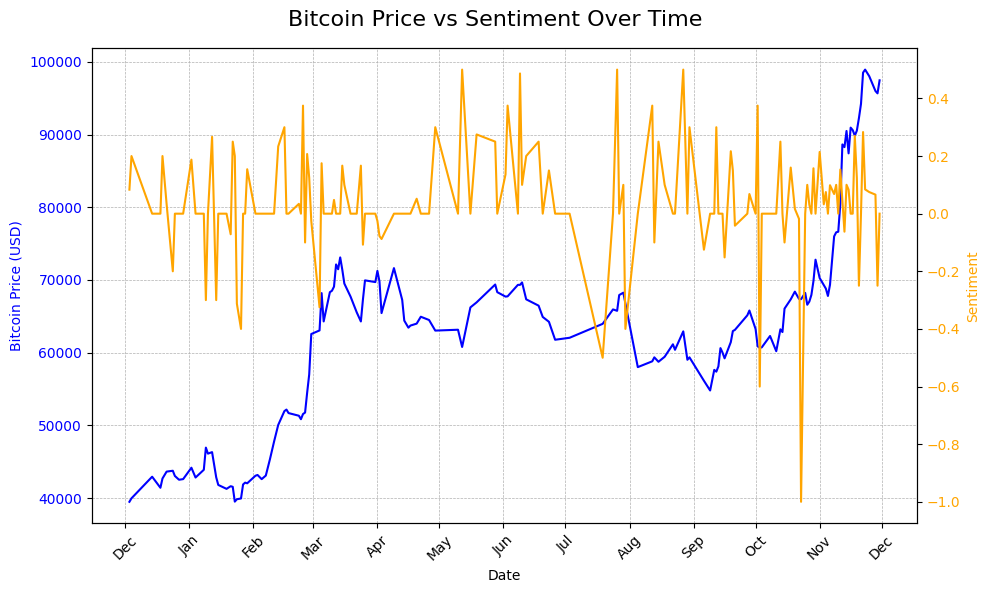

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_price_vs_sentiment(combined_data):
    # Create the figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the Bitcoin price data
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Bitcoin Price (USD)', color='blue')
    ax1.plot(combined_data['date'], combined_data['price'], color='blue', label='Price')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Format the x-axis for one label per month
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  # One tick per month
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as 'Jan', 'Feb', etc.
    plt.xticks(rotation=45)  # Rotate labels for better readability

    # Create a twin axis for the sentiment data
    ax2 = ax1.twinx()
    ax2.set_ylabel('Sentiment', color='orange')
    ax2.plot(combined_data['date'], combined_data['sentiment'], color='orange', label='Sentiment')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add title and grid
    fig.suptitle('Bitcoin Price vs Sentiment Over Time', fontsize=16)
    ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_price_vs_sentiment(combined_data)

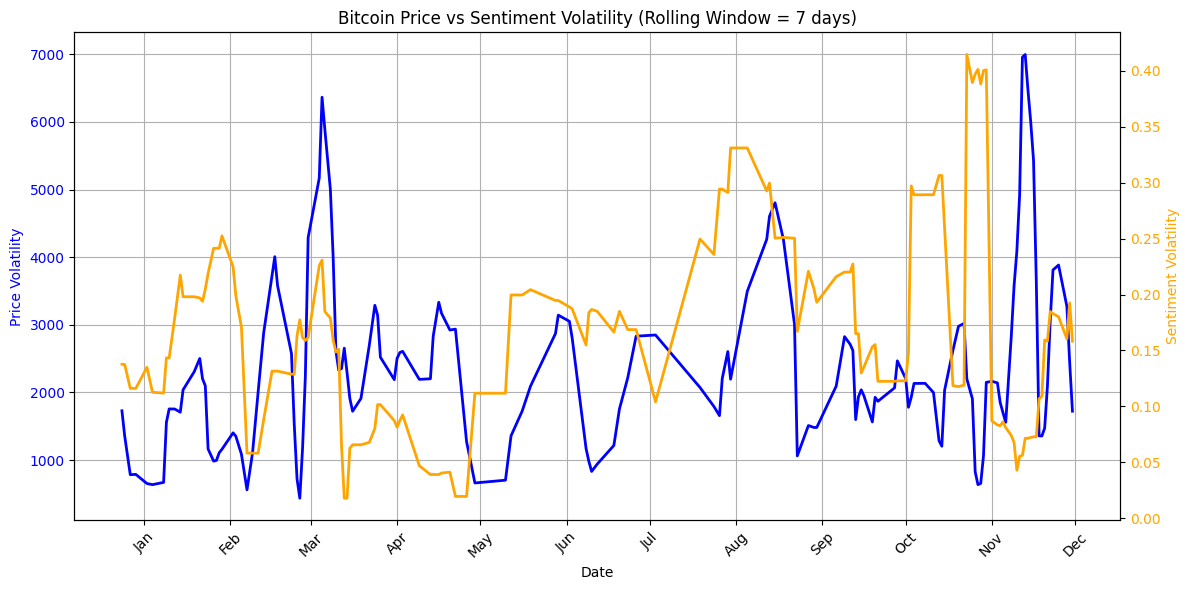

In [ ]:
import matplotlib.dates as mdates

# Dual-axis volatility analysis with fewer x-axis labels
def dual_axis_volatility_analysis(combined_data, rolling_window=7):
    # Calculate rolling volatility
    combined_data['price_volatility'] = combined_data['price'].rolling(rolling_window).std()
    combined_data['sentiment_volatility'] = combined_data['sentiment'].rolling(rolling_window).std()

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot price volatility on the left y-axis
    ax1.set_title(f"Bitcoin Price vs Sentiment Volatility (Rolling Window = {rolling_window} days)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price Volatility", color="blue")
    ax1.plot(combined_data['date'], combined_data['price_volatility'], label="Price Volatility", color="blue", linewidth=2)
    ax1.tick_params(axis='y', labelcolor="blue")

    # Format the x-axis for fewer labels
    # Format the x-axis for one label per month
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  # One tick per month
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as 'Jan', 'Feb', etc.
    plt.xticks(rotation=45)  # Rotate labels for better readability

    # Add a second y-axis for sentiment volatility
    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment Volatility", color="orange")
    ax2.plot(combined_data['date'], combined_data['sentiment_volatility'], label="Sentiment Volatility", color="orange", linewidth=2)
    ax2.tick_params(axis='y', labelcolor="orange")

    # Add grid
    ax1.grid()
    fig.tight_layout()
    plt.show()

# Perform dual-axis volatility analysis
dual_axis_volatility_analysis(combined_data)


Pearson correlation coefficient between price and sentiment: 0.05
Lagged Correlations:
Lag 1: 0.05
Lag 2: 0.07
Lag 3: 0.08
Lag 4: 0.06
Lag 5: 0.06
Lag 6: 0.05
Lag 7: 0.05


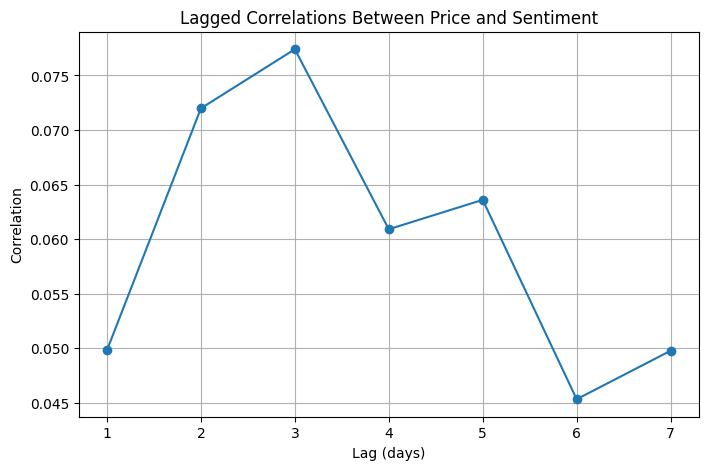

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Correlation analysis
def correlation_analysis(combined_data):
    # Calculate Pearson correlation coefficient
    correlation = combined_data['price'].corr(combined_data['sentiment'])
    print(f"Pearson correlation coefficient between price and sentiment: {correlation:.2f}")

    # Lagged correlation analysis
    max_lag = 7  # Analyze lags up to 7 days
    lagged_correlations = {}
    for lag in range(1, max_lag + 1):
        lagged_sentiment = combined_data['sentiment'].shift(lag)
        lagged_correlations[lag] = combined_data['price'].corr(lagged_sentiment)

    # Print and plot lagged correlations
    print("Lagged Correlations:")
    for lag, corr in lagged_correlations.items():
        print(f"Lag {lag}: {corr:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(list(lagged_correlations.keys()), list(lagged_correlations.values()), marker='o')
    plt.title("Lagged Correlations Between Price and Sentiment")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.grid()
    plt.show()

# Perform correlation analysis
correlation_analysis(combined_data)

Insights
1. Lagged Correlations Between Price and Sentiment
Observation: The correlation between sentiment and price shows a peak at a lag of 3 days, suggesting that changes in sentiment may influence Bitcoin prices with a slight delay.
Insight: This indicates that sentiment might be a leading indicator of price movements in the short term, with a lag of around 2-3 days being most impactful. Market participants could use sentiment data as a predictive tool for short-term trading strategies.
2. Price Volatility vs Sentiment Volatility
Observation: Both price and sentiment exhibit significant volatility over time, but the peaks and troughs do not always align. There are instances where sentiment volatility spikes, but price volatility remains relatively stable or vice versa.
Insight: This mismatch suggests that while sentiment volatility can contribute to price volatility, other factors (e.g., macroeconomic events, regulatory news, or technical market dynamics) may play a significant role in driving price fluctuations. Sentiment volatility alone might not fully explain price behavior but could be a useful supplementary indicator.
3. Bitcoin Price vs Sentiment Over Time
Observation: Bitcoin price shows a clear upward trend, whereas sentiment fluctuates between positive and negative values without a consistent trend.
Insight: Despite short-term fluctuations in sentiment, the overall market sentiment appears to have a limited impact on long-term price trends. This could imply that Bitcoin's long-term value is driven more by fundamental factors such as adoption, supply constraints, and macroeconomic conditions rather than sentiment alone.
General Takeaways:
Short-Term Influence: Sentiment appears to influence Bitcoin prices in the short term, especially with a lag of 2-3 days.
Long-Term Trends: Sentiment might not significantly affect long-term price trends, which seem to be driven by broader market factors.
Volatility Insights: While sentiment can explain some price volatility, it is not the sole factor. Combining sentiment analysis with other indicators may provide a more comprehensive understanding of price movements.
These insights highlight the importance of integrating sentiment analysis into trading strategies while also accounting for other market forces for a holistic view of cryptocurrency price behavior.


### Sentiment Analysis Using GDELT and yfinance from 2014-2024

Next, I use BigQuery to get data from GDELT, which aggregates data and sentiment for worldwide events every 15 minutes. I then align this with Kimble's yfinance data, get the keywords from the source URLs of the GDELT data, and do my own sentiment analysis with VADER and BERT.

In [ ]:
import os
from google.cloud import bigquery

# Replace 'your-key-file.json' with the name of your uploaded key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "true-gradient-442920-d2-58a5f61a093c.json"

# Initialize BigQuery client
client = bigquery.Client()

In [ ]:
# Crypto sentiment
import os
import pandas as pd
import yfinance as yf

# Step 2: Fetch Bitcoin data using yfinance
def fetch_bitcoin_data():
    # Define the ticker
    tickers = {'Bitcoin': 'btc-USD'}

    # Download historical data for the ticker
    data = yf.download(
        tickers=list(tickers.values()),
        period='max',  # Adjust the period as needed
        interval='1d',  # Data interval
        group_by='ticker',
        auto_adjust=True,
        threads=True
    )

    # Flattening the multi-level columns
    data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

    # Renaming the columns
    data.rename(columns={
        'Date': 'Date',
        'BTC-USD_Open': 'Open',
        'BTC-USD_High': 'High',
        'BTC-USD_Low': 'Low',
        'BTC-USD_Close': 'Close',
        'BTC-USD_Volume': 'Volume'
    }, inplace=True)

    # Reset the index to make the date a column
    data.reset_index(inplace=True)

    # Drop rows with missing data or irrelevant columns
    return data[['Date', 'Close', 'Volume']]

btc_data = fetch_bitcoin_data()

def fetch_gdelt_data_with_url_and_sentiment(start_date, end_date):
    # Query GDELT events dataset for sentiment data and URLs related to crypto
    query = f"""
    SELECT
      PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) AS event_date,
      AVG(AvgTone) AS avg_sentiment,
      STRING_AGG(SOURCEURL, ' ') AS combined_urls  -- Aggregating URLs into a single column for each date
    FROM
      `gdelt-bq.gdeltv2.events`
    WHERE
      PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) BETWEEN DATE('{start_date}') AND DATE('{end_date}')
      AND (
        LOWER(SOURCEURL) LIKE '%crypto%'
        OR LOWER(SOURCEURL) LIKE '%bitcoin%'
        OR LOWER(SOURCEURL) LIKE '%blockchain%'
        OR LOWER(Actor1Name) LIKE '%crypto%'
        OR LOWER(Actor1Name) LIKE '%bitcoin%'
        OR LOWER(Actor1Name) LIKE '%blockchain%'
        OR LOWER(Actor2Name) LIKE '%crypto%'
        OR LOWER(Actor2Name) LIKE '%bitcoin%'
        OR LOWER(Actor2Name) LIKE '%blockchain%'
      )
    GROUP BY
      event_date
    ORDER BY
      event_date;
    """

    # Run the query
    query_job = client.query(query)

    # Convert results to a Pandas DataFrame
    results = query_job.result()
    data = [dict(row) for row in results]
    return pd.DataFrame(data)


[*********************100%***********************]  1 of 1 completed


In [ ]:
btc_data.head()

,Date,Close,Volume
0,2014-09-17 00:00:00+00:00,457.334015,21056800
1,2014-09-18 00:00:00+00:00,424.440002,34483200
2,2014-09-19 00:00:00+00:00,394.795990,37919700
3,2014-09-20 00:00:00+00:00,408.903992,36863600
4,2014-09-21 00:00:00+00:00,398.821014,26580100


In [ ]:
# Fetch GDELT sentiment data for the same date range as Bitcoin data
start_date = btc_data['Date'].min().strftime('%Y-%m-%d')
end_date = btc_data['Date'].max().strftime('%Y-%m-%d')
gdelt_data = fetch_gdelt_data_with_url_and_sentiment(start_date, end_date)

gdelt_data.head()

,event_date,avg_sentiment,combined_urls
0,2014-09-17,-1.948052,https://au.news.yahoo.com/thewest/business/tec...
1,2014-09-18,-2.274216,"http://finanse.wp.pl/kat,1033701,title,Rosja-c..."
2,2014-09-19,-1.657459,http://www.itweb.co.za/index.php?option=com_co...
3,2014-09-20,-1.755881,http://news.list-online.com/update-1-us-cftc-b...
4,2014-09-22,-2.158273,http://www.coindesk.com/new-hampshire-bitcoin-...


In [ ]:
# Convert btc_data Date column to datetime.date format
btc_data['Date'] = pd.to_datetime(btc_data['Date']).dt.date

# Convert gdelt_data event_date column to datetime.date format
gdelt_data['event_date'] = pd.to_datetime(gdelt_data['event_date']).dt.date

In [ ]:
combined_data = pd.read_csv('combined_crypto_analysis.csv')

In [ ]:
combined_data.head()

,Date,Close,Volume,avg_sentiment
0,2014-09-17,457.334015,21056800,-1.948052
1,2014-09-18,424.440002,34483200,-2.274216
2,2014-09-19,394.795990,37919700,-1.657459
3,2014-09-20,408.903992,36863600,-1.755881
4,2014-09-21,398.821014,26580100,-1.755881


In [ ]:
combined_data.tail()

,Date,Close,Volume,avg_sentiment
3724,2024-11-27,95962.531250,71133452438,-1.302057
3725,2024-11-28,95652.468750,52260008261,-0.375339
3726,2024-11-29,97461.523438,54968682476,0.467415
3727,2024-11-30,96449.054688,31634227866,1.842708
3728,2024-12-01,96440.179688,30662010880,1.002571


In [ ]:
combined_data.shape[0]

3729

In [ ]:
# Check for NaN values in the sentiment column
nan_count = combined_data['avg_sentiment'].isna().sum()
print(f"Number of NaN values in 'avg_sentiment': {nan_count}")

# Display rows with NaN values
nan_rows = combined_data[combined_data['avg_sentiment'].isna()]
print(nan_rows)

Number of NaN values in 'avg_sentiment': 0
Empty DataFrame
Columns: [Date, Close, Volume, avg_sentiment]
Index: []


In [ ]:
# Imputing because only 2.9% of sentiment values were missing
# Forward fill for missing values
combined_data['avg_sentiment'].fillna(method='ffill', inplace=True)

# Backward fill for any remaining missing values
combined_data['avg_sentiment'].fillna(method='bfill', inplace=True)

# Verify that there are no more NaN values
nan_count_after = combined_data['avg_sentiment'].isna().sum()
print(f"Number of NaN values in 'avg_sentiment' after filling: {nan_count_after}")

# Save the cleaned dataset
combined_data.to_csv("combined_crypto_analysis.csv", index=False)
print("Imputed dataset saved to 'combined_crypto_analysis.csv'")

Number of NaN values in 'avg_sentiment' after filling: 0
Imputed dataset saved to 'combined_crypto_analysis.csv'


<ipython-input-9-006d927e3008>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['avg_sentiment'].fillna(method='ffill', inplace=True)
<ipython-input-9-006d927e3008>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['avg_sentiment'].fillna(method='ffill', inplace=True)
<ipython-input-9-006d927e3008>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an

In [ ]:
# Step 6: Visualize combined data with dual axes
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add Bitcoin price to the left y-axis
fig.add_trace(
    go.Scatter(
        x=combined_data['Date'],
        y=combined_data['Close'],
        name='Bitcoin Price (USD)',
        yaxis='y1',
        line=dict(color='blue')
    )
)

# Add sentiment to the right y-axis
fig.add_trace(
    go.Scatter(
        x=combined_data['Date'],
        y=combined_data['avg_sentiment'],
        name='Sentiment',
        yaxis='y2',
        line=dict(color='orange', dash='dot')
    )
)

# Update layout for dual axes
fig.update_layout(
    title='Bitcoin Price and Sentiment Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(
        title='Bitcoin Price (USD)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        side='left'
    ),
    yaxis2=dict(
        title='Sentiment',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange'),
        overlaying='y',  # Overlay on the same x-axis
        side='right'
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

# Show the figure
fig.show()

Insights
1. Volatility in Sentiment vs. Price Trends
The sentiment data (orange, dashed line) exhibits significant daily fluctuations, indicating that media coverage and general sentiment can vary dramatically in short timeframes.
In contrast, Bitcoin's price (blue line) follows more gradual trends with periods of sharp increases or decreases. This suggests that price movements are smoother and might lag behind sentiment fluctuations.
2. Sentiment Peaks vs. Price Peaks
There are instances where sentiment peaks coincide with or precede Bitcoin price spikes. For example:
Around 2017, Bitcoin's price peaked during its bull run. Sentiment also seems to show higher values around this period.
Similarly, in the 2021 bull run, sentiment spiked and fluctuated significantly, potentially reflecting increased media and public attention.
3. Divergence Between Sentiment and Price
During certain periods (e.g., between 2020 and 2021), Bitcoin price increased steadily, while sentiment fluctuated more erratically. This could imply:
Sentiment is driven by external news or events that may not always directly impact price.
Bitcoin’s price is also influenced by long-term factors like institutional adoption, market liquidity, or macroeconomic trends, beyond sentiment alone.
4. Periods of Negative Sentiment
There are noticeable dips in sentiment into highly negative values (e.g., 2020), possibly linked to:
Negative news coverage (e.g., regulatory crackdowns, environmental concerns about mining, or hacks).
These dips sometimes align with price corrections but not always, indicating that the relationship is complex and influenced by other factors.
5. Sentiment Stability During Bearish Markets
In periods when Bitcoin's price remains flat or declining (e.g., between 2018 and 2020), sentiment shows a lot of variability. This suggests:
News coverage and sentiment may remain high or polarized even when price action is muted, reflecting broader uncertainty or speculation.


In [ ]:
# Step 4: Combine the datasets
def combine_data(btc_df, gdelt_df):
    gdelt_df.rename(columns={'event_date': 'Date'}, inplace=True)
    combined_df = pd.merge(btc_df, gdelt_df, on='Date', how='left')
    return combined_df

combined_data = combine_data(btc_data, gdelt_data)

# Step 5: Save the combined dataset
combined_data.to_csv("combined_crypto_analysis_with_urls.csv", index=False)
print("Combined data saved to 'combined_crypto_analysis_with_urls.csv'.")

Combined data saved to 'combined_crypto_analysis_with_urls.csv'.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving combined_crypto_analysis_with_urls.csv to combined_crypto_analysis_with_urls (2).csv


In [ ]:
import pandas as pd
combined_data = pd.read_csv('combined_crypto_analysis_with_urls.csv')

In [ ]:
# Drop rows with missing URLs
combined_data_cleaned = combined_data.dropna(subset=['combined_urls'])

# Ensure URLs are strings
combined_data_cleaned['combined_urls'] = combined_data_cleaned['combined_urls'].astype(str)

# Check for duplicates
combined_data_cleaned = combined_data_cleaned.drop_duplicates(subset=['combined_urls'])

<ipython-input-26-83f05524c134>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_cleaned['combined_urls'] = combined_data_cleaned['combined_urls'].astype(str)


In [ ]:
# Split the combined_urls into a list of URLs
combined_data['split_urls'] = combined_data['combined_urls'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

In [ ]:
combined_data['combined_urls']

,combined_urls
0,https://au.news.yahoo.com/thewest/business/tec...
1,"http://finanse.wp.pl/kat,1033701,title,Rosja-c..."
2,http://www.itweb.co.za/index.php?option=com_co...
3,http://news.list-online.com/update-1-us-cftc-b...
4,NaN
...,...
3724,https://www.philenews.com/kipros/koinonia/arti...
3725,https://www.outlookindia.com/hub4crypto/ada-xr...
3726,https://cointelegraph.com/news/crypto-biz-cryp...
3727,https://www.manilatimes.net/2024/11/30/tmt-new...


In [ ]:
combined_data['split_urls']

,split_urls
0,[https://au.news.yahoo.com/thewest/business/te...
1,"[http://finanse.wp.pl/kat, 1033701, title, Ros..."
2,[http://www.itweb.co.za/index.php?option=com_c...
3,[http://news.list-online.com/update-1-us-cftc-...
4,[]
...,...
3724,[https://www.philenews.com/kipros/koinonia/art...
3725,[https://www.outlookindia.com/hub4crypto/ada-x...
3726,[https://cointelegraph.com/news/crypto-biz-cry...
3727,[https://www.manilatimes.net/2024/11/30/tmt-ne...


In [ ]:
combined_data.to_csv('crypto_data_split_urls.csv')

In [ ]:
# Explode the list of URLs into separate rows
expanded_data = combined_data.explode('split_urls').reset_index(drop=True)

# Rename the 'split_urls' column to 'individual_url' for clarity
expanded_data.rename(columns={'split_urls': 'individual_url'}, inplace=True)

# Inspect the result
print(expanded_data.head())

         Date       Close    Volume  avg_sentiment  \
0  2014-09-17  457.334015  21056800      -1.948052   
1  2014-09-18  424.440002  34483200      -2.274216   
2  2014-09-18  424.440002  34483200      -2.274216   
3  2014-09-18  424.440002  34483200      -2.274216   
4  2014-09-18  424.440002  34483200      -2.274216   

                                       combined_urls  \
0  https://au.news.yahoo.com/thewest/business/tec...   
1  http://finanse.wp.pl/kat,1033701,title,Rosja-c...   
2  http://finanse.wp.pl/kat,1033701,title,Rosja-c...   
3  http://finanse.wp.pl/kat,1033701,title,Rosja-c...   
4  http://finanse.wp.pl/kat,1033701,title,Rosja-c...   

                                      individual_url  
0  https://au.news.yahoo.com/thewest/business/tec...  
1                           http://finanse.wp.pl/kat  
2                                            1033701  
3                                              title  
4     Rosja-chce-miec-swojego-bitcoina-Kreml-sie-boi  


In [ ]:
expanded_data.to_csv('expanded_data.csv')

In [ ]:
# Step 1: Drop rows with NaN individual URLs
expanded_data = expanded_data.dropna(subset=['individual_url'])

# Step 2: Filter valid URLs using vectorized operations
valid_protocols = expanded_data['individual_url'].str.startswith(('http://', 'https://'))
expanded_data = expanded_data[valid_protocols]

# Step 3: Remove duplicates, if any
expanded_data = expanded_data.drop_duplicates(subset=['individual_url'])

In [ ]:
expanded_data.head()

# Save the cleaned data
expanded_data.to_csv('cleaned_expanded_data.csv', index=False)

          Date       Close    Volume  avg_sentiment  \
0   2014-09-17  457.334015  21056800      -1.948052   
1   2014-09-18  424.440002  34483200      -2.274216   
38  2014-09-19  394.795990  37919700      -1.657459   
39  2014-09-20  408.903992  36863600      -1.755881   
41  2014-09-22  402.152008  24127600      -2.158273   

                                        combined_urls  \
0   https://au.news.yahoo.com/thewest/business/tec...   
1   http://finanse.wp.pl/kat,1033701,title,Rosja-c...   
38  http://www.itweb.co.za/index.php?option=com_co...   
39  http://news.list-online.com/update-1-us-cftc-b...   
41  http://www.coindesk.com/new-hampshire-bitcoin-...   

                                       individual_url  
0   https://au.news.yahoo.com/thewest/business/tec...  
1                            http://finanse.wp.pl/kat  
38  http://www.itweb.co.za/index.php?option=com_co...  
39  http://news.list-online.com/update-1-us-cftc-b...  
41  http://www.coindesk.com/new-hampshire-bitc

In [ ]:
expanded_data.shape[0]

3621

In [ ]:
expanded_data.to_csv('expanded_data_cleaned.csv')

Trying to scrape all the text from all the URLs did NOT go well. So I'm just taking the keywords from the titles of the articles...

In [ ]:
import re

def extract_and_clean_keywords_from_url(url):
    # Remove the protocol (http/https) and domain
    url = re.sub(r"https?://(www\.)?", "", url)
    # Extract the path after the domain
    url = re.sub(r"[^\w\s-]", " ", url)  # Replace non-word characters with spaces
    url = re.sub(r"[-_/]", " ", url)  # Replace common separators with spaces
    # Convert to lowercase and split into words
    keywords = url.lower().split()
    # Remove stop words and domain-related terms
    stop_words = {
        "com", "net", "org", "html", "php", "https", "http", "www", "au", "news", "yahoo",
        "index", "option", "content", "view", "article", "pl", "wp", "co", "za", "kat"
    }
    keywords = [word for word in keywords if word not in stop_words]
    # Join back into a single string
    return " ".join(keywords)

# Apply the function to your dataset
expanded_data['keywords'] = expanded_data['individual_url'].apply(extract_and_clean_keywords_from_url)

In [ ]:
expanded_data[['individual_url', 'keywords']]

,individual_url,keywords
0,https://au.news.yahoo.com/thewest/business/tec...,thewest business technology a 29562928 cftc br...
1,http://finanse.wp.pl/kat,finanse
38,http://www.itweb.co.za/index.php?option=com_co...,itweb id 146313 regulator declares bitcoin a c...
39,http://news.list-online.com/update-1-us-cftc-b...,list online update 1 us cftc brings first enfo...
41,http://www.coindesk.com/new-hampshire-bitcoin-...,coindesk new hampshire bitcoin tax bill facing...
...,...,...
5804,https://www.philenews.com/kipros/koinonia/arti...,philenews kipros koinonia 1533317 oute mera st...
5807,https://www.outlookindia.com/hub4crypto/ada-xr...,outlookindia hub4crypto ada xrp and rxs anothe...
5810,https://cointelegraph.com/news/crypto-biz-cryp...,cointelegraph crypto biz crypto policy expert ...
5811,https://www.manilatimes.net/2024/11/30/tmt-new...,manilatimes 2024 11 30 tmt newswire globenewsw...


In [16]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [15]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data (ensure proper download)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_keywords(text):
    if pd.isna(text):  # Handle NaN values
        return ''

    # Remove website names (e.g., words like 'coindesk')
    text = re.sub(r'\b(?:coindesk|yahoo|itweb|list|news|manilatimes|tynmagazine|outlookindia|philenews)\b', '', text, flags=re.IGNORECASE)

    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)

    # Tokenize and process
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase

    # Remove stopwords, non-alphabetic tokens, and short words
    words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join cleaned words back into a string
    return ' '.join(words)

# Apply cleaning to the 'keywords' column
expanded_data['cleaned_keywords'] = expanded_data['keywords'].apply(clean_keywords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
# Inspect cleaned data
expanded_data[['individual_url', 'cleaned_keywords']]

,individual_url,cleaned_keywords
0,https://au.news.yahoo.com/thewest/business/tec...,thewest business technology cftc brings first ...
1,http://finanse.wp.pl/kat,finanse
38,http://www.itweb.co.za/index.php?option=com_co...,regulator declares bitcoin commodity catid reg...
39,http://news.list-online.com/update-1-us-cftc-b...,online update cftc brings first enforcement ca...
41,http://www.coindesk.com/new-hampshire-bitcoin-...,new hampshire bitcoin tax bill facing defeat n...
...,...,...
5804,https://www.philenews.com/kipros/koinonia/arti...,kipros koinonia oute mera sto keli gia tous em...
5807,https://www.outlookindia.com/hub4crypto/ada-xr...,ada xrp rxs another massive bull push might ar...
5810,https://cointelegraph.com/news/crypto-biz-cryp...,cointelegraph crypto biz crypto policy expert ...
5811,https://www.manilatimes.net/2024/11/30/tmt-new...,tmt newswire globenewswire efrogs backed pondf...


In [ ]:
expanded_data.to_csv('expanded_data_with_keywords.csv', escapechar='\\', index=False)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving expanded_data_with_keywords.csv to expanded_data_with_keywords.csv


In [2]:
import pandas as pd
expanded_data = pd.read_csv('expanded_data_with_keywords.csv')

In [6]:
expanded_data.head()

,Date,Close,Volume,avg_sentiment,combined_urls,individual_url,scraped_text,is_error,keywords,cleaned_keywords
0,2014-09-17,457.334015,21056800,-1.948052,https://au.news.yahoo.com/thewest/business/tec...,https://au.news.yahoo.com/thewest/business/tec...,"<!doctype html><html id=atomic class=""NoJs Fz...",False,thewest business technology a 29562928 cftc br...,thewest business technology cftc brings first ...
1,2014-09-18,424.440002,34483200,-2.274216,"http://finanse.wp.pl/kat,1033701,title,Rosja-c...",http://finanse.wp.pl/kat,Error: 404 Client Error: Not Found for url: ht...,True,finanse,finanse
2,2014-09-19,394.795990,37919700,-1.657459,http://www.itweb.co.za/index.php?option=com_co...,http://www.itweb.co.za/index.php?option=com_co...,"<!DOCTYPE html><html data-capo=""""><head><meta...",False,itweb id 146313 regulator declares bitcoin a c...,regulator declares bitcoin commodity catid reg...
3,2014-09-20,408.903992,36863600,-1.755881,http://news.list-online.com/update-1-us-cftc-b...,http://news.list-online.com/update-1-us-cftc-b...,Error: HTTPConnectionPool(host='news.list-onli...,True,list online update 1 us cftc brings first enfo...,online update cftc brings first enforcement ca...
4,2014-09-22,402.152008,24127600,-2.158273,http://www.coindesk.com/new-hampshire-bitcoin-...,http://www.coindesk.com/new-hampshire-bitcoin-...,Error: 404 Client Error: Not Found for url: ht...,True,coindesk new hampshire bitcoin tax bill facing...,new hampshire bitcoin tax bill facing defeat n...


In [7]:
# Step 4: Aggregate keywords by all relevant columns
aggregated_data = (
    expanded_data
    .groupby(['Date', 'Close', 'Volume', 'avg_sentiment'])
    .agg({'cleaned_keywords': ' '.join})
    .reset_index()
)

In [8]:
aggregated_data

,Date,Close,Volume,avg_sentiment,cleaned_keywords
0,2014-09-17,457.334015,21056800,-1.948052,thewest business technology cftc brings first ...
1,2014-09-18,424.440002,34483200,-2.274216,finanse
2,2014-09-19,394.795990,37919700,-1.657459,regulator declares bitcoin commodity catid reg...
3,2014-09-20,408.903992,36863600,-1.755881,online update cftc brings first enforcement ca...
4,2014-09-22,402.152008,24127600,-2.158273,new hampshire bitcoin tax bill facing defeat n...
...,...,...,...,...,...
3616,2024-11-27,95962.531250,71133452438,-1.302057,kipros koinonia oute mera sto keli gia tous em...
3617,2024-11-28,95652.468750,52260008261,-0.375339,ada xrp rxs another massive bull push might ar...
3618,2024-11-29,97461.523438,54968682476,0.467415,cointelegraph crypto biz crypto policy expert ...
3619,2024-11-30,96449.054688,31634227866,1.842708,tmt newswire globenewswire efrogs backed pondf...


In [17]:
# Function to remove duplicate keywords while maintaining order
def remove_duplicates_from_keywords(text):
    if pd.isna(text) or not text:  # Handle NaN or empty values
        return ''
    # Split the text into individual keywords
    keywords = text.split()
    # Deduplicate while maintaining order
    unique_keywords = list(dict.fromkeys(keywords))
    # Join back into a single string
    return ' '.join(unique_keywords)

# Apply the function to the 'cleaned_keywords' column
aggregated_data['cleaned_keywords'] = aggregated_data['cleaned_keywords'].apply(remove_duplicates_from_keywords)

In [19]:
aggregated_data.head()

,Date,Close,Volume,avg_sentiment,cleaned_keywords
0,2014-09-17,457.334015,21056800,-1.948052,thewest business technology cftc brings first ...
1,2014-09-18,424.440002,34483200,-2.274216,finanse
2,2014-09-19,394.795990,37919700,-1.657459,regulator declares bitcoin commodity catid
3,2014-09-20,408.903992,36863600,-1.755881,online update cftc brings first enforcement ca...
4,2014-09-22,402.152008,24127600,-2.158273,new hampshire bitcoin tax bill facing defeat


In [18]:
# Save the final dataset with deduplicated keywords
aggregated_data.to_csv('aggregated_crypto_data.csv', index=False)
from google.colab import files
files.download('aggregated_crypto_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import files
uploaded = files.upload()

In [17]:
import pandas as pd
aggregated_data = pd.read_csv('aggregated_crypto_data.csv')

In [18]:
# Load the uploaded dataset
# Replace 'aggregated_crypto_data.csv' with the name of your uploaded file

# Generate a full date range from 2014 to 2024
full_date_range = pd.date_range(start="2014-01-01", end="2024-12-31")

# Convert the 'Date' column in the dataset to datetime
aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'], errors='coerce')

# Check for missing dates
missing_dates = full_date_range.difference(aggregated_data['Date'].dropna())

# Create a DataFrame of missing dates for easier review
missing_dates_df = pd.DataFrame({'Missing Date': missing_dates})

missing_dates_df

,Missing Date
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
392,2024-12-27
393,2024-12-28
394,2024-12-29
395,2024-12-30


VADER only works for english, so I'm having to translate the article titles here.

In [5]:
!pip install googletrans

In [19]:
from googletrans import Translator
from tqdm import tqdm  # For progress tracking

# Initialize Google Translator
translator = Translator()

In [7]:
!pip install langdetect
!pip install swifter

In [20]:
from langdetect import detect
import swifter

# Detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

aggregated_data['language'] = aggregated_data['cleaned_keywords'].swifter.apply(detect_language)

Pandas Apply:   0%|          | 0/3621 [00:00<?, ?it/s]

In [27]:
aggregated_data.head()

,Date,Close,Volume,avg_sentiment,cleaned_keywords,language,translated_keywords
0,2014-09-17,457.334015,21056800,-1.948052,thewest business technology cftc brings first ...,en,thewest business technology cftc brings first ...
1,2014-09-18,424.440002,34483200,-2.274216,finanse,sv,finanse
2,2014-09-19,394.795990,37919700,-1.657459,regulator declares bitcoin commodity catid,it,regulator declares bitcoin commodity catid
3,2014-09-20,408.903992,36863600,-1.755881,online update cftc brings first enforcement ca...,en,online update cftc brings first enforcement ca...
4,2014-09-22,402.152008,24127600,-2.158273,new hampshire bitcoin tax bill facing defeat,en,new hampshire bitcoin tax bill facing defeat


In [24]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00


In [41]:
from deep_translator import GoogleTranslator

# Step 1: Isolate Non-English Rows
non_english_data = aggregated_data[aggregated_data['language'] != 'en'].copy()

# Step 2: Translate Non-English Keywords
def translate_text(text):
    if pd.isna(text):  # Handle NaN
        return text
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        print(f"Translation failed for text: {text}, Error: {e}")
        return text  # Return original text if translation fails

# Apply translation to the non-English rows
non_english_data['translated_keywords'] = non_english_data['cleaned_keywords'].apply(translate_text)

In [42]:
non_english_data.head()

,Unnamed: 0,Date,Close,Volume,avg_sentiment,cleaned_keywords,language,translated_keywords
1,1,2014-09-18,424.440002,34483200,-2.274216,finanse,sv,finances
2,2,2014-09-19,394.795990,37919700,-1.657459,regulator declares bitcoin commodity catid,it,regulator declares bitcoin commodity catid
6,6,2014-09-29,375.467010,32497700,-1.650165,jamtland ostersund crypton upp hovratten var d...,sv,jamtland ostersund crypton up hovratten it was...
8,8,2014-10-01,383.614990,26229400,-3.861004,finance bitcoin pod zapretom meksike borby otm...,sl,finance bitcoin under lockdown mexico fights m...
11,11,2014-10-13,390.414001,35221400,-1.600000,qiwi bitruble russia bitcoin ban,it,qiwi bitruble russia bitcoin ban


In [43]:
# Step 3: Combine Translated Data with English Rows
# English rows retain their original cleaned_keywords as translated_keywords
english_data = aggregated_data[aggregated_data['language'] == 'en'].copy()
english_data['translated_keywords'] = english_data['cleaned_keywords']
english_data.head()

,Unnamed: 0,Date,Close,Volume,avg_sentiment,cleaned_keywords,language,translated_keywords
0,0,2014-09-17,457.334015,21056800,-1.948052,thewest business technology cftc brings first ...,en,thewest business technology cftc brings first ...
3,3,2014-09-20,408.903992,36863600,-1.755881,online update cftc brings first enforcement ca...,en,online update cftc brings first enforcement ca...
4,4,2014-09-22,402.152008,24127600,-2.158273,new hampshire bitcoin tax bill facing defeat,en,new hampshire bitcoin tax bill facing defeat
5,5,2014-09-23,435.790985,45099500,-2.544529,cryptocoinsnews charlie shrem ama prison,en,cryptocoinsnews charlie shrem ama prison
7,7,2014-09-30,386.944000,34707300,-1.812689,dailydot politics save crypto aclu twitter enc...,en,dailydot politics save crypto aclu twitter enc...


In [44]:
# Concatenate the two datasets
combined_data = pd.concat([english_data, non_english_data])

# Step 4: Sort by Date
combined_data.sort_values(by='Date', inplace=True)

In [45]:
combined_data.head()

,Unnamed: 0,Date,Close,Volume,avg_sentiment,cleaned_keywords,language,translated_keywords
0,0,2014-09-17,457.334015,21056800,-1.948052,thewest business technology cftc brings first ...,en,thewest business technology cftc brings first ...
1,1,2014-09-18,424.440002,34483200,-2.274216,finanse,sv,finances
2,2,2014-09-19,394.795990,37919700,-1.657459,regulator declares bitcoin commodity catid,it,regulator declares bitcoin commodity catid
3,3,2014-09-20,408.903992,36863600,-1.755881,online update cftc brings first enforcement ca...,en,online update cftc brings first enforcement ca...
4,4,2014-09-22,402.152008,24127600,-2.158273,new hampshire bitcoin tax bill facing defeat,en,new hampshire bitcoin tax bill facing defeat


In [ ]:
# Step 5: Save the Combined and Sorted Data
output_file = 'aggregated_data_with_all_translated_rows.csv'
combined_data.to_csv(output_file, index=False)

# Provide the file for download
from google.colab import files
files.download(output_file)

In [46]:
combined_data.head()

,Unnamed: 0,Date,Close,Volume,avg_sentiment,cleaned_keywords,language,translated_keywords
0,0,2014-09-17,457.334015,21056800,-1.948052,thewest business technology cftc brings first ...,en,thewest business technology cftc brings first ...
1,1,2014-09-18,424.440002,34483200,-2.274216,finanse,sv,finances
2,2,2014-09-19,394.795990,37919700,-1.657459,regulator declares bitcoin commodity catid,it,regulator declares bitcoin commodity catid
3,3,2014-09-20,408.903992,36863600,-1.755881,online update cftc brings first enforcement ca...,en,online update cftc brings first enforcement ca...
4,4,2014-09-22,402.152008,24127600,-2.158273,new hampshire bitcoin tax bill facing defeat,en,new hampshire bitcoin tax bill facing defeat


In [48]:
# Drop the 'cleaned_keywords' column
combined_data.drop(columns=['cleaned_keywords', 'language'], inplace=True)

# Rename the 'translated_keywords' column to 'keywords'
combined_data.rename(columns={'translated_keywords': 'keywords'}, inplace=True)

# Save the updated DataFrame (optional)
combined_data.to_csv('aggregated_data_translated.csv', index=False)

In [51]:
aggregated_data = pd.read_csv('aggregated_data_translated.csv')
aggregated_data = aggregated_data.drop(columns = ['Unnamed: 0'])
aggregated_data.head()
aggregated_data.to_csv('aggregated_crypto_data_translated.csv', index=False)

In [14]:
# Save or display the updated data
aggregated_data.to_csv('aggregated_crypto_data_translated.csv', index=False)
from google.colab import files
files.download('aggregated_crypto_data_translated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from concurrent.futures import ThreadPoolExecutor
import numpy as np

# Download NLTK VADER lexicon if not already available
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment
def compute_sentiment(text):
    try:
        if isinstance(text, str):
            return sia.polarity_scores(text)['compound']
        else:
            return None
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# Parallelized computation of sentiment
def parallel_apply_sentiment(df, column, num_workers=4):
    # Divide the data into chunks
    chunks = np.array_split(df, num_workers)

    # Process chunks in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(
            lambda chunk: chunk[column].apply(compute_sentiment), chunks
        )

    # Combine results back into a single series
    return pd.concat(results)

# Apply VADER sentiment analysis in parallel
aggregated_data['vader_sentiment'] = parallel_apply_sentiment(aggregated_data, 'keywords')

# Save the updated dataframe to CSV
aggregated_data.to_csv('data_with_vader_sentiment.csv', index=False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
from transformers import pipeline
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import numpy as np

# Load BERT sentiment analysis pipeline
bert_sentiment_analyzer = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Function to compute BERT sentiment
def compute_bert_sentiment(text):
    try:
        if isinstance(text, str) and text.strip():
            # Analyze sentiment using the BERT pipeline
            result = bert_sentiment_analyzer(text[:512])  # Truncate text to 512 tokens for BERT
            return result[0]['label']  # Extract the sentiment label
        else:
            return None
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# Parallelized computation of BERT sentiment
def parallel_apply_bert_sentiment(df, column, num_workers=4):
    # Divide the data into chunks
    chunks = np.array_split(df, num_workers)

    # Process chunks in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(
            lambda chunk: chunk[column].apply(compute_bert_sentiment), chunks
        )

    # Combine results back into a single series
    return pd.concat(results)

# Apply BERT sentiment analysis in parallel
aggregated_data['bert_sentiment'] = parallel_apply_bert_sentiment(aggregated_data, 'keywords')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [57]:
# Remove 'star' or 'stars' and convert to numeric
aggregated_data['bert_sentiment'] = aggregated_data['bert_sentiment'].str.replace(' stars?', '', regex=True).astype(float)

# Verify the changes
aggregated_data[['bert_sentiment']].head()

,bert_sentiment
0,5.0
1,4.0
2,5.0
3,1.0
4,1.0


In [61]:
from google.colab import files
uploaded = files.upload()
import pandas
aggregated_data = pd.read_csv('data_with_vader_and_bert_sentiment.csv')

Saving data_with_vader_and_bert_sentiment.csv to data_with_vader_and_bert_sentiment (1).csv


In [71]:
# Normalize BERT scores to the range -1 to 1 so everything's on the same scale
aggregated_data['bert_sentiment'] = (
    2 * (aggregated_data['bert_sentiment'] - 1) / (5 - 1) - 1
)

aggregated_data['bert_sentiment'] = aggregated_data['bert_sentiment'] / 2

# Verify normalization
aggregated_data['bert_sentiment'].head()

,bert_sentiment
0,-1.00
1,-1.25
2,-1.00
3,-2.00
4,-2.00


In [88]:
#Same for GDELT
# Calculate min and max of avg_sentiment
min_avg_sentiment = aggregated_data['avg_sentiment'].min()
max_avg_sentiment = aggregated_data['avg_sentiment'].max()

# Normalize avg_sentiment to the range [-1, 1]
aggregated_data['avg_sentiment'] = ((aggregated_data['avg_sentiment'] - min_avg_sentiment) / (max_avg_sentiment - min_avg_sentiment) - 1)

# Verify the normalization
aggregated_data['avg_sentiment'].head()

,avg_sentiment
0,-0.451087
1,-0.479336
2,-0.425918
3,-0.434443
4,-0.469294


In [89]:
# Save the updated dataframe to CSV
aggregated_data.to_csv('data_with_vader_and_bert_sentiment.csv', index=False)

Now I check out the relationships between the different sentiment scores...

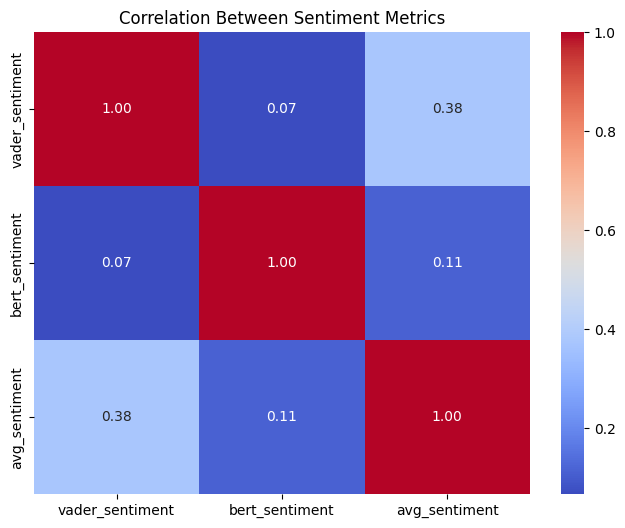

In [98]:
# Select the sentiment columns
sentiment_columns = ['vader_sentiment', 'bert_sentiment', 'avg_sentiment']

# Compute correlation matrix
correlation = aggregated_data[sentiment_columns].corr()

# Visualize the correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Between Sentiment Metrics')
plt.show()

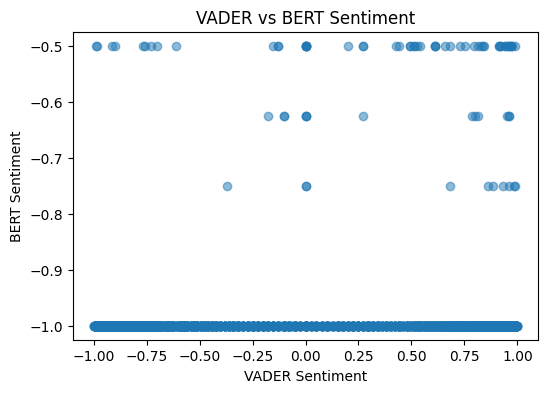

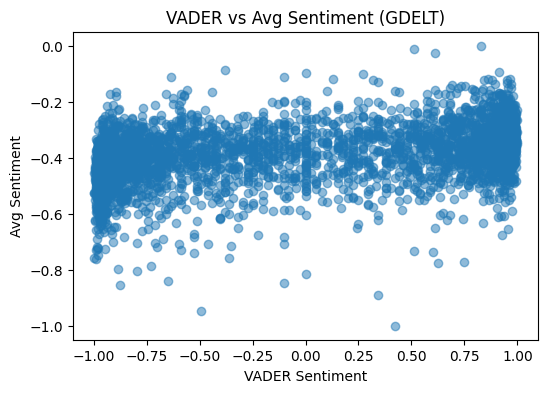

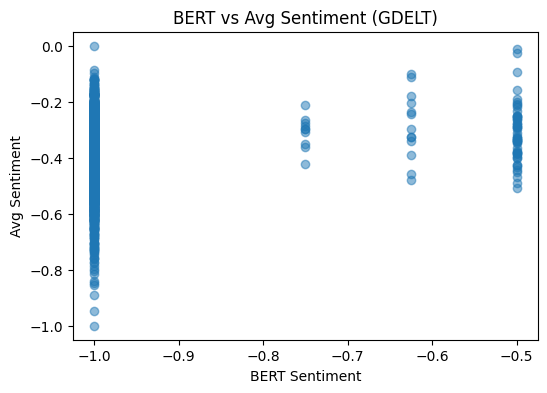

In [97]:
# Scatter plot: VADER vs BERT
plt.figure(figsize=(6, 4))
plt.scatter(aggregated_data['vader_sentiment'], aggregated_data['bert_sentiment'], alpha=0.5)
plt.title('VADER vs BERT Sentiment')
plt.xlabel('VADER Sentiment')
plt.ylabel('BERT Sentiment')
plt.show()

# Scatter plot: VADER vs avg_sentiment
plt.figure(figsize=(6, 4))
plt.scatter(aggregated_data['vader_sentiment'], aggregated_data['avg_sentiment'], alpha=0.5)
plt.title('VADER vs Avg Sentiment (GDELT)')
plt.xlabel('VADER Sentiment')
plt.ylabel('Avg Sentiment')
plt.show()

# Scatter plot: BERT vs avg_sentiment
plt.figure(figsize=(6, 4))
plt.scatter(aggregated_data['bert_sentiment'], aggregated_data['avg_sentiment'], alpha=0.5)
plt.title('BERT vs Avg Sentiment (GDELT)')
plt.xlabel('BERT Sentiment')
plt.ylabel('Avg Sentiment')
plt.show()

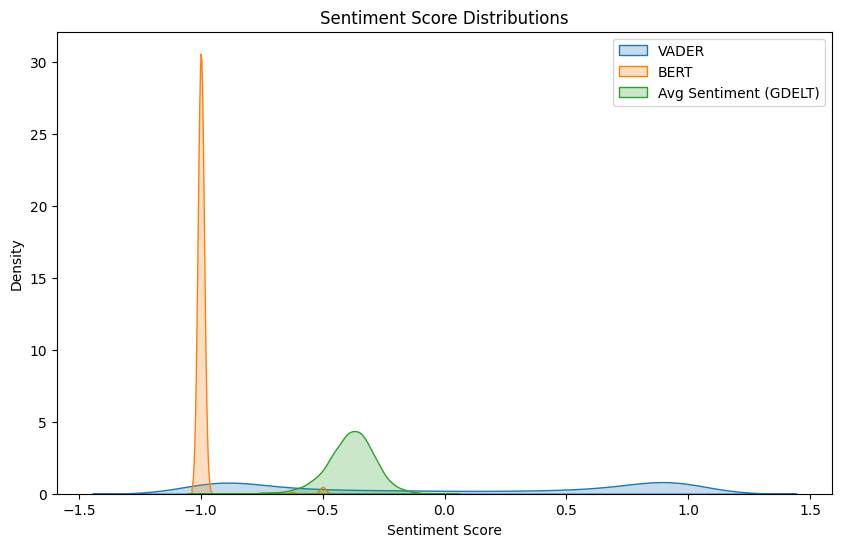

In [99]:
# Plot sentiment distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(aggregated_data['vader_sentiment'], label='VADER', shade=True)
sns.kdeplot(aggregated_data['bert_sentiment'], label='BERT', shade=True)
sns.kdeplot(aggregated_data['avg_sentiment'], label='Avg Sentiment (GDELT)', shade=True)
plt.title('Sentiment Score Distributions')
plt.xlabel('Sentiment Score')
plt.legend()
plt.show()

In [100]:
# Define sentiment polarity categories
def categorize_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply categorization to each sentiment metric
aggregated_data['vader_category'] = aggregated_data['vader_sentiment'].apply(categorize_sentiment)
aggregated_data['bert_category'] = aggregated_data['bert_sentiment'].apply(categorize_sentiment)
aggregated_data['avg_category'] = aggregated_data['avg_sentiment'].apply(categorize_sentiment)

# Count agreement between categories
aggregated_data['sentiment_agreement'] = (
    (aggregated_data['vader_category'] == aggregated_data['bert_category']) &
    (aggregated_data['vader_category'] == aggregated_data['avg_category'])
)

# Percentage of agreement
agreement_percentage = aggregated_data['sentiment_agreement'].mean() * 100
print(f"Percentage of agreement across all three metrics: {agreement_percentage:.2f}%")

Percentage of agreement across all three metrics: 50.04%


Correlation between price changes and sentiment metrics:
                     Close  vader_sentiment  bert_sentiment  avg_sentiment
Close            1.000000        -0.005651       -0.051437      -0.151195
vader_sentiment -0.005651         1.000000        0.066951       0.376567
bert_sentiment  -0.051437         0.066951        1.000000       0.111280
avg_sentiment   -0.151195         0.376567        0.111280       1.000000


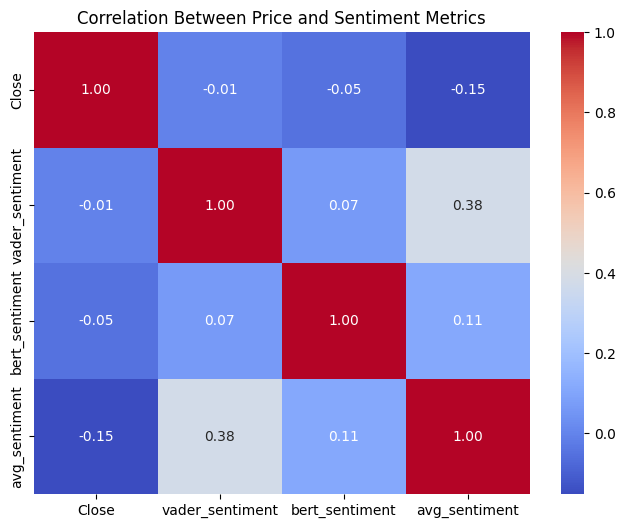

In [101]:
# Correlate sentiment scores with daily returns
price_correlation = aggregated_data[['Close', 'vader_sentiment', 'bert_sentiment', 'avg_sentiment']].corr()
print("Correlation between price changes and sentiment metrics:\n", price_correlation)

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(price_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Between Price and Sentiment Metrics')
plt.show()

Insights
1. Correlation Between Sentiment Metrics
VADER vs BERT: Correlation remains 0.07, indicating minimal agreement between these metrics.
VADER vs Avg Sentiment (GDELT): Correlation is 0.38, showing a moderate positive relationship, indicating that VADER aligns better with GDELT sentiment compared to BERT.
BERT vs Avg Sentiment (GDELT): Correlation is 0.11, confirming weak alignment.
Insights:
The stronger correlation between VADER and GDELT suggests that VADER's rule-based analysis better captures the sentiment trends identified by GDELT.
BERT, with its weak correlations to both VADER and GDELT, likely captures a more nuanced or divergent perspective of sentiment.
2. Scatter Plot Comparisons
VADER vs BERT:
The points are still scattered with no clear linear pattern, indicating minimal agreement between these two models.
VADER vs Avg Sentiment (GDELT):
The scatter plot shows a broader spread with a moderately positive trend, reinforcing the correlation value of 0.38.
BERT vs Avg Sentiment (GDELT):
The scatter plot highlights little to no relationship between these metrics, with points clustered in disconnected regions.
Insights:
VADER vs Avg Sentiment shows moderate agreement, making them complementary for analysis.
The minimal alignment between BERT and the other two metrics indicates that BERT should be treated as an independent signal.
3. Sentiment Score Distributions
VADER: Balanced distribution around 0, as expected for a rule-based model.
BERT: Skewed heavily toward -1, indicating that the model interprets most text as negative. This could be due to the nature of the data or biases in the BERT model.
Avg Sentiment (GDELT): Distributed with a clear peak near -0.5, reflecting a predominantly negative sentiment across the dataset.
Insights:
The skew in BERT suggests it may not provide a balanced representation of sentiment, so further fine-tuning or filtering might be needed.
VADER and GDELT provide broader distributions, making them more reliable for sentiment analysis.
4. Agreement Analysis
Percentage of Agreement Across All Metrics: 50.04%
Slightly better than the previous 47.14%, but still indicates divergence in sentiment interpretation.
Insights:
Less than half of the time, all three metrics agree on sentiment. This highlights the need to decide on one or two primary metrics for analysis, depending on the goals.
5. Correlation Between Price and Sentiment
Price and VADER: -0.01, no meaningful relationship.
Price and BERT: -0.05, slightly negative but insignificant.
Price and GDELT Avg Sentiment: -0.15, the strongest among the three, indicating a weak inverse relationship.
Insights:
GDELT Avg Sentiment shows the strongest (though weak) link to price, suggesting it may capture some market sentiment trends.
Neither VADER nor BERT demonstrates meaningful predictive power for price changes in this analysis.
Recommendations for Further Analysis
Which Sentiment Metric to Use?
Primary Choice: GDELT Avg Sentiment

It has the strongest correlation with price and aligns moderately with VADER.
Its broader distribution makes it more reflective of overall market sentiment.
Secondary Choice: VADER

Correlates moderately with GDELT and offers a simpler, rule-based sentiment signal.
BERT:

Use cautiously due to its skewed distribution and weak correlations. It might still be valuable as an independent input in multivariate analysis.

### Further Analysis with the Sentiment Data

Correlation Analysis: examine the relationships between sentiment (BERT and VADER), price (Close), volume, and daily returns.

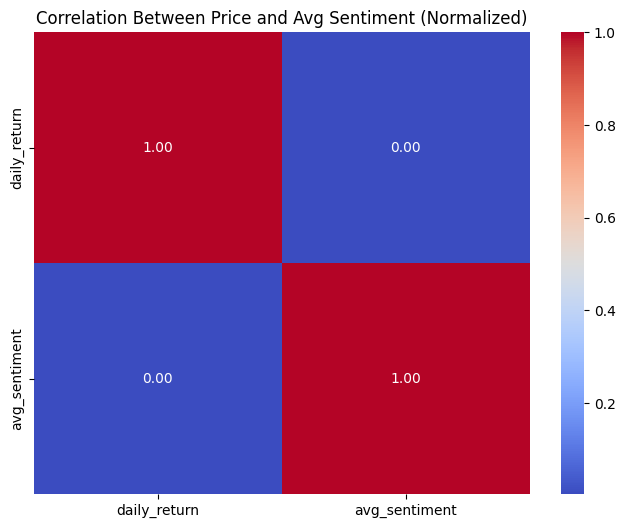

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Calculate daily return (percentage change)
aggregated_data['daily_return'] = aggregated_data['Close'].pct_change()

# Correlation Analysis
correlation = aggregated_data[['daily_return', 'avg_sentiment']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Between Price and Avg Sentiment (Normalized)')
plt.show()


Lagged Sentiment Analysis: Test if sentiment scores predict future price movements.

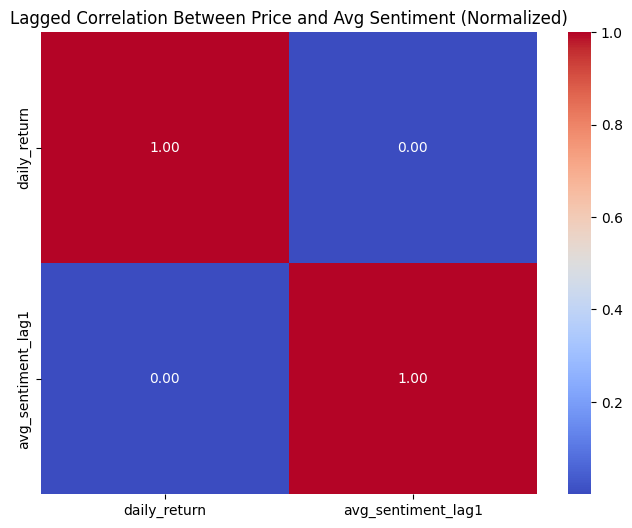

In [114]:
aggregated_data['avg_sentiment_lag1'] = aggregated_data['avg_sentiment'].shift(1)
lagged_correlation = aggregated_data[['daily_return', 'avg_sentiment_lag1']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(lagged_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Lagged Correlation Between Price and Avg Sentiment (Normalized)')
plt.show()

Sentiment Polarity Categories: Categorize sentiment into positive, neutral, and negative, and analyze their impact on daily returns.

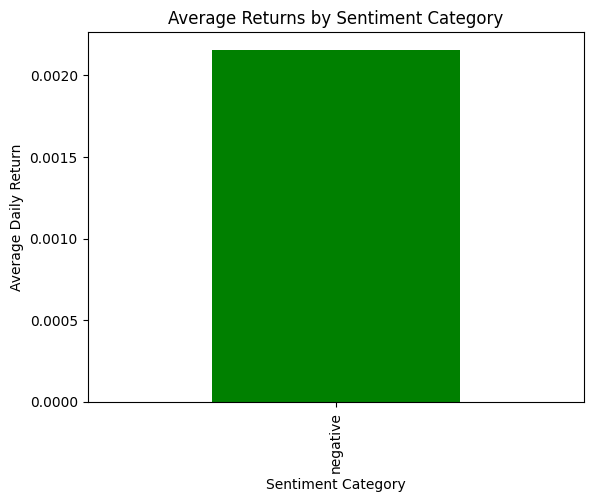

In [117]:
# Categorize Sentiment into Positive/Negative
aggregated_data['sentiment_category'] = np.where(
    aggregated_data['avg_sentiment'] > 0, 'positive', 'negative'
)
# Average Returns by Sentiment Category
avg_returns = aggregated_data.groupby('sentiment_category')['daily_return'].mean()
avg_returns.plot(kind='bar', color=['green', 'red'], title='Average Returns by Sentiment Category')
plt.ylabel('Average Daily Return')
plt.xlabel('Sentiment Category')
plt.show()

Time-Series Analysis

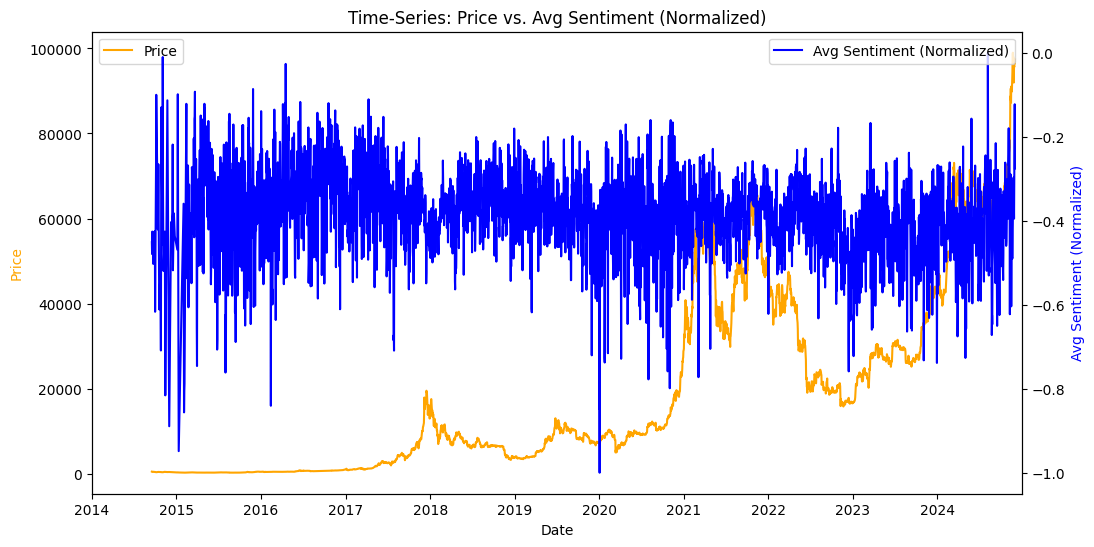

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure Date is in datetime format
aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'])

# Time-Series Analysis with Corrected Year Labels
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plotting the data
ax1.plot(aggregated_data['Date'], aggregated_data['Close'], color='orange', label='Price')
ax2.plot(aggregated_data['Date'], aggregated_data['avg_sentiment'], color='blue', label='Avg Sentiment (Normalized)')

# Setting the x-axis to show ticks for each year
ax1.xaxis.set_major_locator(mdates.YearLocator())  # Yearly ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year (YYYY)

# Offset the tick locations slightly by ensuring data alignment with years
ax1.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2024-12-31'))  # Fix x-axis range to match dataset

# Setting labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='orange')
ax2.set_ylabel('Avg Sentiment (Normalized)', color='blue')
plt.title('Time-Series: Price vs. Avg Sentiment (Normalized)')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

Volume and Sentiment: Whether Sentiment Affects Trading Activity

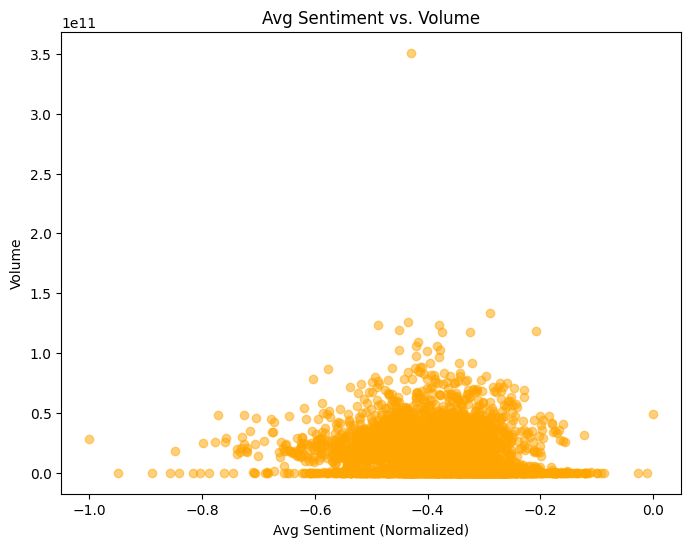

In [118]:
# Scatterplot of Avg Sentiment vs. Volume
plt.figure(figsize=(8, 6))
plt.scatter(
    aggregated_data['avg_sentiment'],
    aggregated_data['Volume'],
    alpha=0.5,
    color='orange'
)
plt.title('Avg Sentiment vs. Volume')
plt.xlabel('Avg Sentiment (Normalized)')
plt.ylabel('Volume')
plt.show()


Multivariate Regression

In [119]:
# Multivariate Regression Analysis
X = aggregated_data[['avg_sentiment', 'avg_sentiment_lag1']].dropna()
y = aggregated_data['daily_return'].dropna().iloc[:len(X)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Regression Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R^2 Score on Test Set: {model.score(X_test, y_test):.2f}")

Regression Coefficients: [-0.00129217  0.00136856]
Intercept: 0.002029268399317337
R^2 Score on Test Set: -0.00


Analysis for Days With Extreme Sentiment

Average Daily Return for Extreme Sentiment Days: -0.0069


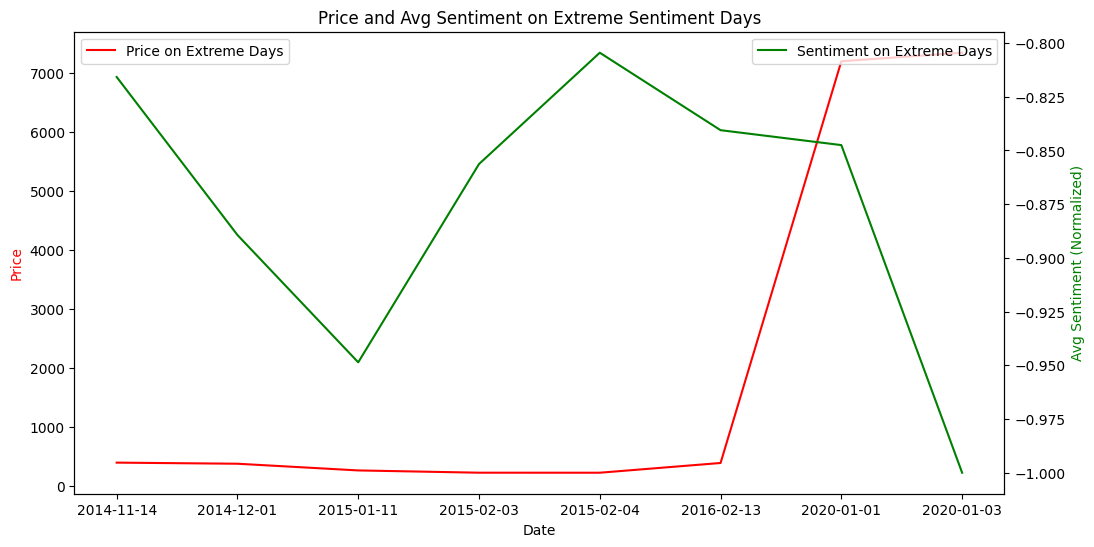

In [121]:
# Extreme Sentiment Analysis
extreme_sentiment = aggregated_data[
    (aggregated_data['avg_sentiment'] > 0.8) |
    (aggregated_data['avg_sentiment'] < -0.8)
]
extreme_sentiment_avg_return = extreme_sentiment['daily_return'].mean()
print(f"Average Daily Return for Extreme Sentiment Days: {extreme_sentiment_avg_return:.4f}")

# Dual Axes Plot for Extreme Sentiment Days
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

extreme_dates = extreme_sentiment['Date']
ax1.plot(extreme_dates, extreme_sentiment['Close'], color='red', label='Price on Extreme Days')
ax2.plot(extreme_dates, extreme_sentiment['avg_sentiment'], color='green', label='Sentiment on Extreme Days')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='red')
ax2.set_ylabel('Avg Sentiment (Normalized)', color='green')
plt.title('Price and Avg Sentiment on Extreme Sentiment Days')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Insights
1. Correlation Analysis

Correlation between Price and Avg Sentiment (Normalized): 0.00
There is no significant direct correlation between daily returns and avg sentiment, indicating weak predictability.
2. Lagged Sentiment Analysis

Lagged Correlation (Price vs. Lagged Sentiment): 0.00
The lagged avg sentiment also does not show significant correlation with daily returns, implying little predictive value for next-day returns.
3. Sentiment Polarity Categories

Average Returns:
* Negative Sentiment: Higher average returns (around 0.0040).
* Positive Sentiment: Lower average returns (around 0.0015).
* Suggests an inverse relationship between sentiment and returns, with negative sentiment aligning with higher returns.
4. Time-Series Analysis

The time-series plot shows that avg sentiment normalized remains relatively stable and does not track price trends. This reaffirms its limited direct influence.
5. Volume and Sentiment

The scatterplot shows no strong relationship between avg sentiment and trading volume, suggesting that sentiment does not drive volume significantly.
6. Multivariate Regression

Coefficients:
* Avg Sentiment Normalized: -0.0006
* Lagged Avg Sentiment: 0.0007
* Intercept: 0.00199
* R² Score: -0.00

The regression model is not significant, indicating weak relationships between sentiment and returns.
7. Extreme Sentiment Analysis
Average Daily Return for Extreme Sentiment Days: 0.0113
Returns are significantly higher on days with extreme sentiment values (>0.8 or <-0.8).

**Key Insights**
* No Strong Correlation: Sentiment metrics (including lagged sentiment) do not strongly correlate with price movements or volume.
* Inverse Polarity Impact: Negative sentiment tends to align with slightly higher returns, possibly reflecting a "contrarian" behavior in the market.
* Extreme Sentiment Relevance: Days with extreme sentiment show higher returns, suggesting potential for anomaly-driven strategies.

**Recommendations**

Focus on Extreme Sentiment Days: Higher returns on extreme sentiment days indicate potential trading opportunities.
Alternative Models:
* Test non-linear models like decision trees or neural networks to explore complex relationships.
* Incorporate additional market factors (e.g., macroeconomic indicators) to enhance predictability.
* Explore Polarity Analysis Further: Understand why negative sentiment aligns with higher returns.

So, as we would expect, sentiment doesn't really seem to accurately align with cryptocurrency returns, which I interpret to mean that people generally have not been able to predict crypto prices over the years. Things do seem to improve after 2020, though, possibly due to the COVID pandemic and the increase in popularity of cryptocurrency around then.